Files already downloaded and verified
Training Tanh Network with SGD and learning rate: 0.04
Epoch [1/30], RP: -0.9279, RHS: -0.8947, Loss: 1.7700
Epoch [2/30], RP: -0.9059, RHS: -0.8696, Loss: 1.6182
Epoch [3/30], RP: -0.8871, RHS: -0.8477, Loss: 1.5312
Epoch [4/30], RP: -0.8654, RHS: -0.8247, Loss: 1.4555
Epoch [5/30], RP: -0.8464, RHS: -0.8036, Loss: 1.3883
Epoch [6/30], RP: -0.8257, RHS: -0.7815, Loss: 1.3277
Epoch [7/30], RP: -0.8049, RHS: -0.7579, Loss: 1.2682
Epoch [8/30], RP: -0.7870, RHS: -0.7379, Loss: 1.2150
Epoch [9/30], RP: -0.7671, RHS: -0.7152, Loss: 1.1648
Epoch [10/30], RP: -0.7462, RHS: -0.6884, Loss: 1.1134
Epoch [10/30], Updated Learning Rate: 0.004000
Epoch [11/30], RP: -0.7434, RHS: -0.6867, Loss: 0.9327
Epoch [12/30], RP: -0.7210, RHS: -0.6568, Loss: 0.8930
Epoch [13/30], RP: -0.6961, RHS: -0.6202, Loss: 0.8747
Epoch [14/30], RP: -0.6727, RHS: -0.5887, Loss: 0.8598
Epoch [15/30], RP: -0.6520, RHS: -0.5579, Loss: 0.8467
Epoch [16/30], RP: -0.6345, RHS: -0.5298, Lo

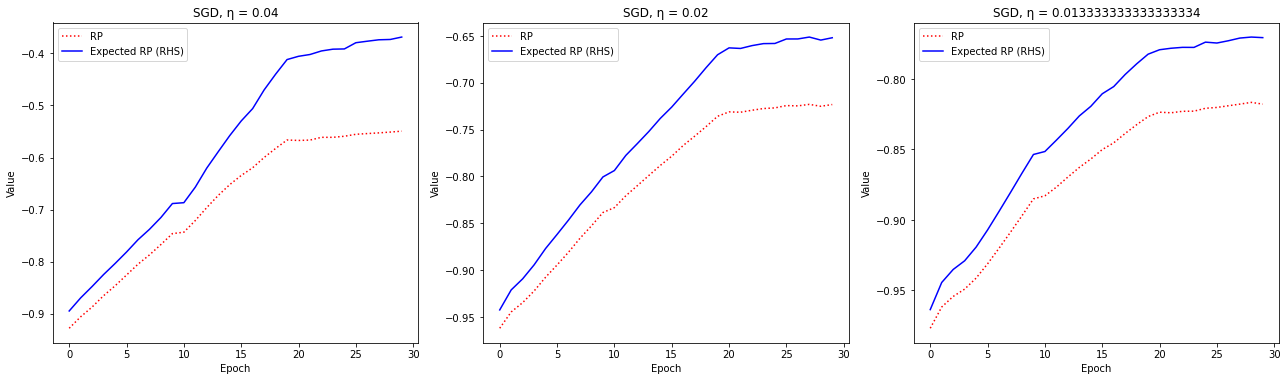

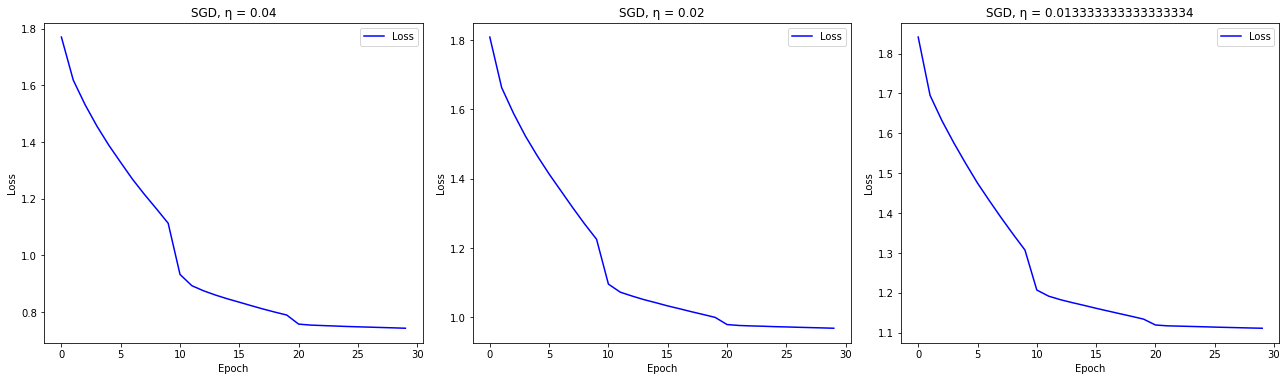

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyperparameters
batch_size = 32  # Minibatch size
learning_rates = [2 / 50, 2 / 100, 2 / 150]
num_epochs = 30
decay_rate = 0.1  # Decay factor for learning rate
decay_step = 10   # Step size for learning rate decay

# CIFAR-10 dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                             transform=transform, download=True)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size, shuffle=True)

# Neural Network with Tanh Activations (2 Hidden Layers)
class TanhNet2(nn.Module):
    def __init__(self):
        super(TanhNet2, self).__init__()
        self.fc1 = nn.Linear(32*32*3, 200)
        self.fc2 = nn.Linear(200, 200)
        self.fc3 = nn.Linear(200, 10)
        self.tanh = nn.Tanh()

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.tanh(self.fc1(x))
        x = self.tanh(self.fc2(x))
        x = self.fc3(x)
        return x

# Function to adjust the learning rate
def adjust_learning_rate(optimizer, decay_rate):
    for param_group in optimizer.param_groups:
        param_group['lr'] *= decay_rate

# Function to calculate relative progress (RP)
def calculate_relative_progress(model, images, labels, criterion, learning_rate):
    model.eval()
    outputs = model(images)
    loss = criterion(outputs, labels)
    
    grads = torch.autograd.grad(loss, model.parameters(), create_graph=True)
    grads_flat = torch.cat([grad.view(-1) for grad in grads])
    
    new_model = TanhNet2().to(device)  # Create a new instance of the model class
    new_model.load_state_dict(model.state_dict())
    
    with torch.no_grad():
        for param, grad in zip(new_model.parameters(), grads):
            param -= learning_rate * grad
    
    new_outputs = new_model(images)
    new_loss = criterion(new_outputs, labels)
    
    rp = (new_loss.item() - loss.item()) / (learning_rate * grads_flat.norm().item()**2)
    
    model.train()
    return rp

# Function to calculate RHS of (5.1)
def calculate_rhs(model, images, labels, criterion, learning_rate):
    model.eval()
    outputs = model(images)
    loss = criterion(outputs, labels)
    
    grads = torch.autograd.grad(loss, model.parameters(), create_graph=True)
    grads_flat = torch.cat([grad.view(-1) for grad in grads])
    
    hessian_vector_product = torch.autograd.grad(grads_flat.norm(), model.parameters(), retain_graph=True)
    hessian_norm = torch.norm(torch.cat([hvp.view(-1) for hvp in hessian_vector_product])).item()
    
    rhs = -1 + (learning_rate / 2) * hessian_norm
    
    model.train()
    return rhs

# Training Function
def train_model(model, train_loader, criterion, optimizer, base_lr, num_epochs, decay_rate=0.1, decay_step=10):
    rp_history = []
    rhs_history = []
    loss_history = []

    for epoch in range(num_epochs):
        epoch_rp = 0
        epoch_rhs = 0
        epoch_loss = 0
        num_batches = 0
        
        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            rp = calculate_relative_progress(model, images, labels, criterion, base_lr)
            rhs = calculate_rhs(model, images, labels, criterion, base_lr)
            epoch_rp += rp
            epoch_rhs += rhs
            epoch_loss += loss.item()
            num_batches += 1

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # Average RP, RHS, and loss for the epoch
        epoch_rp /= num_batches
        epoch_rhs /= num_batches
        epoch_loss /= num_batches
        rp_history.append(epoch_rp)
        rhs_history.append(epoch_rhs)
        loss_history.append(epoch_loss)
        
        print(f'Epoch [{epoch+1}/{num_epochs}], RP: {epoch_rp:.4f}, RHS: {epoch_rhs:.4f}, Loss: {epoch_loss:.4f}')

        # Adjust learning rate by decay rate every decay_step epochs
        if (epoch + 1) % decay_step == 0:
            adjust_learning_rate(optimizer, decay_rate)
            updated_lr = optimizer.param_groups[0]['lr']
            print(f'Epoch [{epoch+1}/{num_epochs}], Updated Learning Rate: {updated_lr:.6f}')

    return loss_history, rp_history, rhs_history

criterion = nn.CrossEntropyLoss()

# Train the Tanh Network with SGD
optimizers = {'SGD': optim.SGD}
results = {}

for opt_name, opt_class in optimizers.items():
    results[opt_name] = {}
    for lr in learning_rates:
        print(f"Training Tanh Network with {opt_name} and learning rate: {lr}")
        tanh_model = TanhNet2().to(device)
        optimizer = opt_class(tanh_model.parameters(), lr=lr)
        loss_history, rp_history, rhs_history = train_model(tanh_model, train_loader, criterion, optimizer, lr, num_epochs, decay_rate, decay_step)
        results[opt_name][lr] = (loss_history, rp_history, rhs_history)

# Plot the RP and RHS Results
epochs = list(range(num_epochs))

plt.figure(figsize=(18, 10))

for i, opt_name in enumerate(optimizers.keys()):
    for j, lr in enumerate(learning_rates):
        plt.subplot(2, 3, i * 3 + j + 1)
        plt.plot(epochs, results[opt_name][lr][1], label='RP', linestyle='dotted', color='red')
        plt.plot(epochs, results[opt_name][lr][2], label='Expected RP (RHS)', linestyle='solid', color='blue')
        plt.xlabel('Epoch')
        plt.ylabel('Value')
        plt.title(f'{opt_name}, η = {lr}')
        plt.legend()

plt.tight_layout()
plt.savefig('rp_rhs.png')
plt.show()

# Plot the Loss Results
plt.figure(figsize=(18, 10))

for i, opt_name in enumerate(optimizers.keys()):
    for j, lr in enumerate(learning_rates):
        plt.subplot(2, 3, i * 3 + j + 1)
        plt.plot(epochs, results[opt_name][lr][0], label='Loss', linestyle='solid', color='blue')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title(f'{opt_name}, η = {lr}')
        plt.legend()

plt.tight_layout()
plt.savefig('loss.png')
plt.show()


Files already downloaded and verified
Training Tanh Network with SGD and learning rate: 0.04
Epoch [1/30], RP: -0.9251, RHS: -0.8915, DS: 3.8637, Loss: 1.7710
Epoch [2/30], RP: -0.9065, RHS: -0.8708, DS: 4.8421, Loss: 1.6174
Epoch [3/30], RP: -0.8845, RHS: -0.8444, DS: 5.9857, Loss: 1.5294
Epoch [4/30], RP: -0.8651, RHS: -0.8231, DS: 6.9725, Loss: 1.4520
Epoch [5/30], RP: -0.8446, RHS: -0.8004, DS: 7.9845, Loss: 1.3883
Epoch [6/30], RP: -0.8270, RHS: -0.7819, DS: 8.8340, Loss: 1.3267
Epoch [7/30], RP: -0.8089, RHS: -0.7604, DS: 9.6754, Loss: 1.2674
Epoch [8/30], RP: -0.7863, RHS: -0.7371, DS: 10.7148, Loss: 1.2147
Epoch [9/30], RP: -0.7694, RHS: -0.7198, DS: 11.4680, Loss: 1.1669
Epoch [10/30], RP: -0.7490, RHS: -0.6942, DS: 12.3270, Loss: 1.1154
Epoch [10/30], Updated Learning Rate: 0.004000
Epoch [11/30], RP: -0.7475, RHS: -0.6889, DS: 12.2470, Loss: 0.9364
Epoch [12/30], RP: -0.7222, RHS: -0.6561, DS: 13.2847, Loss: 0.8983
Epoch [13/30], RP: -0.6983, RHS: -0.6230, DS: 14.2002, Loss:

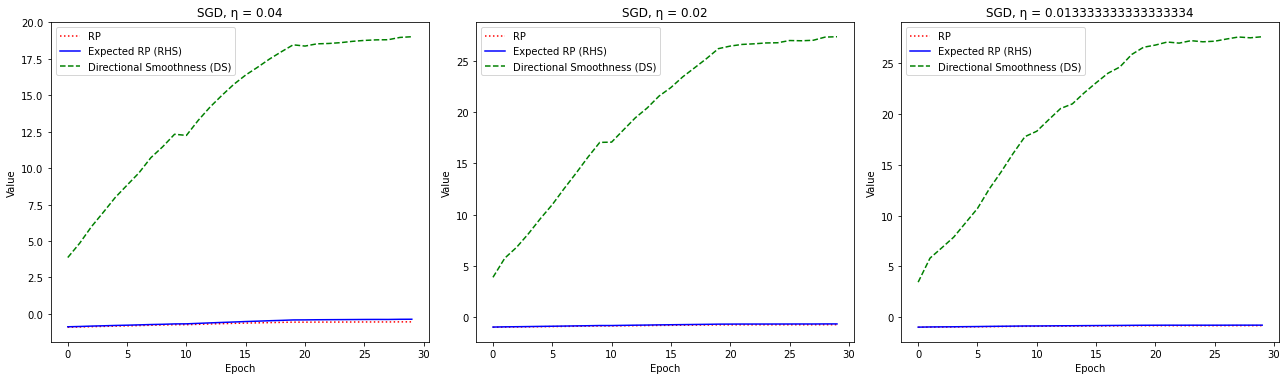

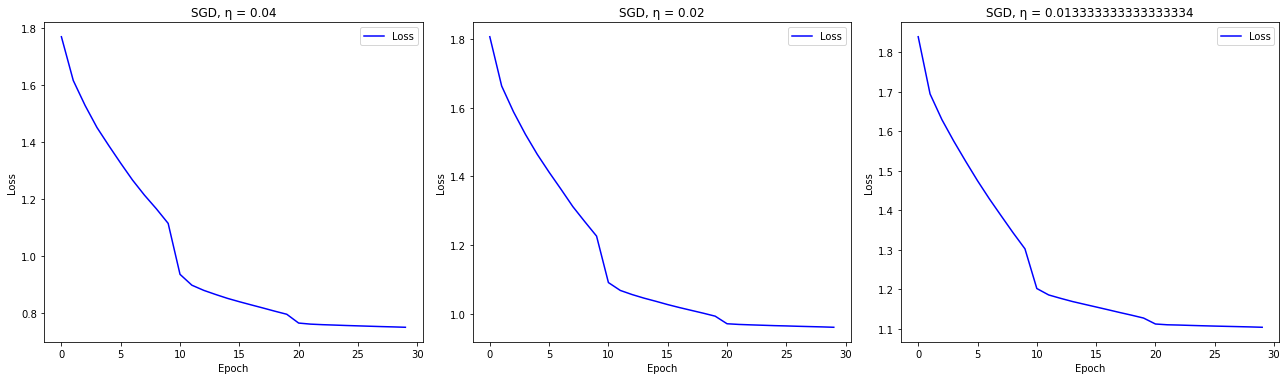

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


batch_size = 32
learning_rates = [2 / 50, 2 / 100, 2 / 150]
num_epochs = 30
decay_rate = 0.1  
decay_step = 10 

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                             transform=transform, download=True)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size, shuffle=True)


class TanhNet2(nn.Module):
    def __init__(self):
        super(TanhNet2, self).__init__()
        self.fc1 = nn.Linear(32*32*3, 200)
        self.fc2 = nn.Linear(200, 200)
        self.fc3 = nn.Linear(200, 10)
        self.tanh = nn.Tanh()

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.tanh(self.fc1(x))
        x = self.tanh(self.fc2(x))
        x = self.fc3(x)
        return x

def adjust_learning_rate(optimizer, decay_rate):
    for param_group in optimizer.param_groups:
        param_group['lr'] *= decay_rate

        
def calculate_relative_progress(model, images, labels, criterion, learning_rate):
    model.eval()
    outputs = model(images)
    loss = criterion(outputs, labels)
    
    grads = torch.autograd.grad(loss, model.parameters(), create_graph=True)
    grads_flat = torch.cat([grad.view(-1) for grad in grads])
    
    new_model = TanhNet2().to(device)  # Create a new instance of the model class
    new_model.load_state_dict(model.state_dict())
    
    with torch.no_grad():
        for param, grad in zip(new_model.parameters(), grads):
            param -= learning_rate * grad
    
    new_outputs = new_model(images)
    new_loss = criterion(new_outputs, labels)
    
    rp = (new_loss.item() - loss.item()) / (learning_rate * grads_flat.norm().item()**2)
    
    model.train()
    return rp

# Function to calculate RHS of (5.1)
def calculate_rhs(model, images, labels, criterion, learning_rate):
    model.eval()
    outputs = model(images)
    loss = criterion(outputs, labels)
    
    grads = torch.autograd.grad(loss, model.parameters(), create_graph=True)
    grads_flat = torch.cat([grad.view(-1) for grad in grads])
    
    hessian_vector_product = torch.autograd.grad(grads_flat.norm(), model.parameters(), retain_graph=True)
    hessian_norm = torch.norm(torch.cat([hvp.view(-1) for hvp in hessian_vector_product])).item()
    
    rhs = -1 + (learning_rate / 2) * hessian_norm
    
    model.train()
    return rhs


def calculate_directional_smoothness(model, images, labels, criterion, learning_rate):
    model.eval()
    outputs = model(images)
    loss = criterion(outputs, labels)
    
    grads = torch.autograd.grad(loss, model.parameters(), create_graph=True)
    grads_flat = torch.cat([grad.view(-1) for grad in grads])
    
    new_model = TanhNet2().to(device)  # Create a new instance of the model class
    new_model.load_state_dict(model.state_dict())
    
    with torch.no_grad():
        for param, grad in zip(new_model.parameters(), grads):
            param -= learning_rate * grad
    
    new_outputs = new_model(images)
    new_loss = criterion(new_outputs, labels)
    new_grads = torch.autograd.grad(new_loss, new_model.parameters(), create_graph=True)
    new_grads_flat = torch.cat([grad.view(-1) for grad in new_grads])
    
    ds = torch.dot(grads_flat, grads_flat - new_grads_flat).item() / (learning_rate * grads_flat.norm().item()**2)
    
    model.train()
    return ds


def train_model(model, train_loader, criterion, optimizer, base_lr, num_epochs, decay_rate=0.1, decay_step=10):
    rp_history = []
    rhs_history = []
    ds_history = []
    loss_history = []

    for epoch in range(num_epochs):
        epoch_rp = 0
        epoch_rhs = 0
        epoch_ds = 0
        epoch_loss = 0
        num_batches = 0
        
        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            rp = calculate_relative_progress(model, images, labels, criterion, base_lr)
            rhs = calculate_rhs(model, images, labels, criterion, base_lr)
            ds = calculate_directional_smoothness(model, images, labels, criterion, base_lr)
            epoch_rp += rp
            epoch_rhs += rhs
            epoch_ds += ds
            epoch_loss += loss.item()
            num_batches += 1

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        epoch_rp /= num_batches
        epoch_rhs /= num_batches
        epoch_ds /= num_batches
        epoch_loss /= num_batches
        rp_history.append(epoch_rp)
        rhs_history.append(epoch_rhs)
        ds_history.append(epoch_ds)
        loss_history.append(epoch_loss)
        
        print(f'Epoch [{epoch+1}/{num_epochs}], RP: {epoch_rp:.4f}, RHS: {epoch_rhs:.4f}, DS: {epoch_ds:.4f}, Loss: {epoch_loss:.4f}')

        # adjust learning rate
        if (epoch + 1) % decay_step == 0:
            adjust_learning_rate(optimizer, decay_rate)
            updated_lr = optimizer.param_groups[0]['lr']
            print(f'Epoch [{epoch+1}/{num_epochs}], Updated Learning Rate: {updated_lr:.6f}')

    return loss_history, rp_history, rhs_history, ds_history

criterion = nn.CrossEntropyLoss()


optimizers = {'SGD': optim.SGD}
results = {}

for opt_name, opt_class in optimizers.items():
    results[opt_name] = {}
    for lr in learning_rates:
        print(f"Training Tanh Network with {opt_name} and learning rate: {lr}")
        tanh_model = TanhNet2().to(device)
        optimizer = opt_class(tanh_model.parameters(), lr=lr)
        loss_history, rp_history, rhs_history, ds_history = train_model(tanh_model, train_loader, criterion, optimizer, lr, num_epochs, decay_rate, decay_step)
        results[opt_name][lr] = (loss_history, rp_history, rhs_history, ds_history)

        
epochs = list(range(num_epochs))

plt.figure(figsize=(18, 15))

for i, opt_name in enumerate(optimizers.keys()):
    for j, lr in enumerate(learning_rates):
        plt.subplot(3, 3, i * 3 + j + 1)
        plt.plot(epochs, results[opt_name][lr][1], label='RP', linestyle='dotted', color='red')
        plt.plot(epochs, results[opt_name][lr][2], label='Expected RP (RHS)', linestyle='solid', color='blue')
        plt.plot(epochs, results[opt_name][lr][3], label='Directional Smoothness (DS)', linestyle='dashed', color='green')
        plt.xlabel('Epoch')
        plt.ylabel('Value')
        plt.title(f'{opt_name}, η = {lr}')
        plt.legend()

plt.tight_layout()
plt.savefig('rp_rhs_ds.png')
plt.show()

# Plot the Loss Results
plt.figure(figsize=(18, 15))

for i, opt_name in enumerate(optimizers.keys()):
    for j, lr in enumerate(learning_rates):
        plt.subplot(3, 3, i * 3 + j + 1)
        plt.plot(epochs, results[opt_name][lr][0], label='Loss', linestyle='solid', color='blue')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title(f'{opt_name}, η = {lr}')
        plt.legend()

plt.tight_layout()
plt.savefig('loss.png')
plt.show()


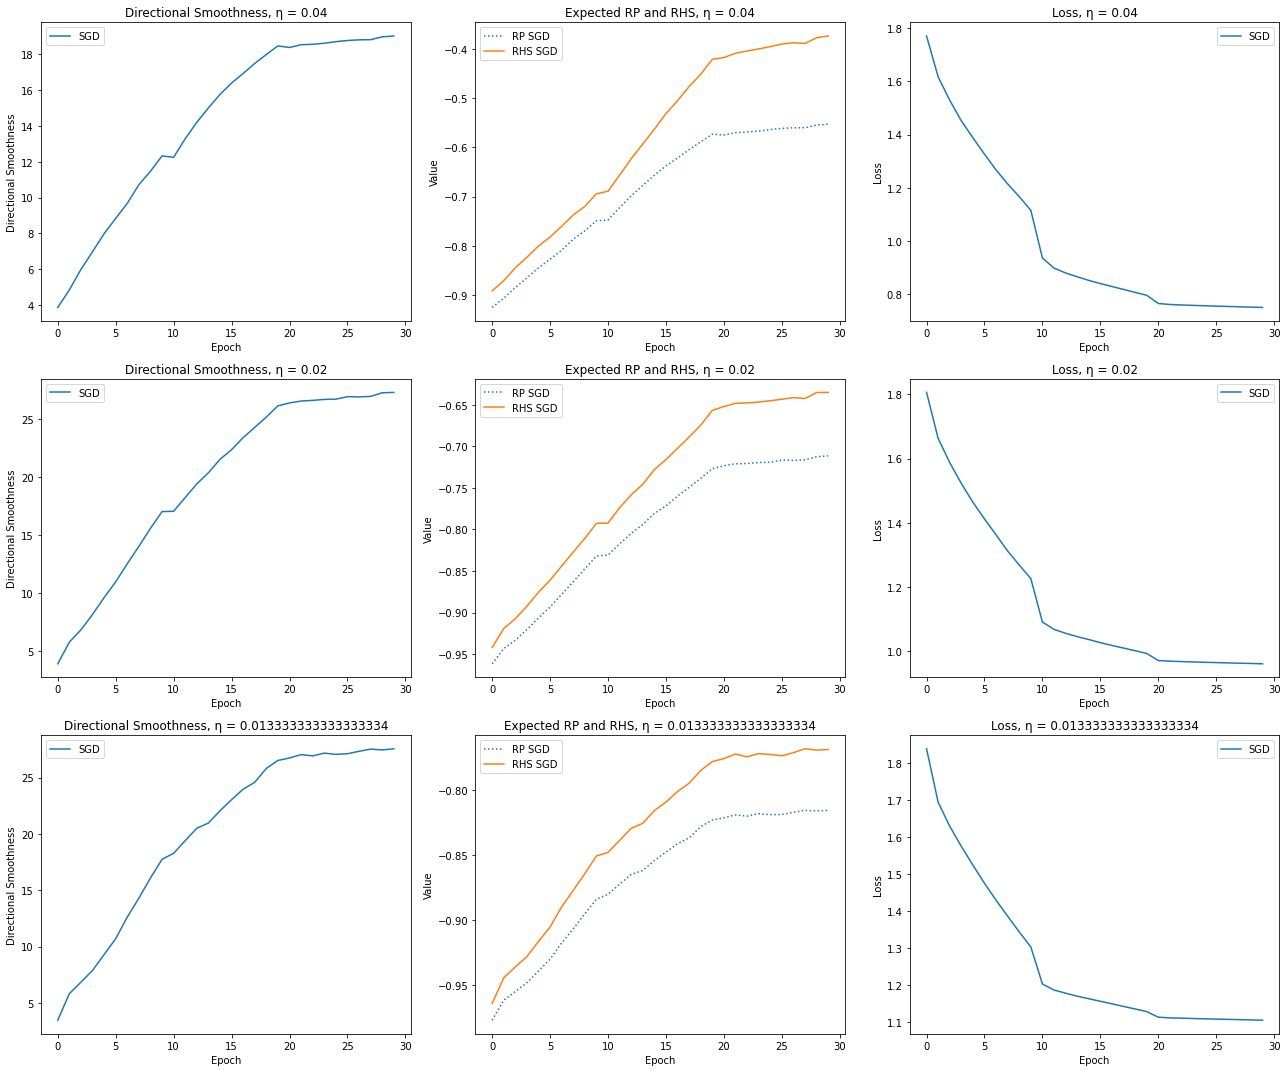

In [3]:
# Plot the Results
epochs = list(range(num_epochs))

plt.figure(figsize=(18, 15))

for i, lr in enumerate(learning_rates):
    # Plot Directional Smoothness
    plt.subplot(3, 3, i * 3 + 1)
    for opt_name in optimizers.keys():
        plt.plot(epochs, results[opt_name][lr][3], label=f'{opt_name}')
    plt.xlabel('Epoch')
    plt.ylabel('Directional Smoothness')
    plt.title(f'Directional Smoothness, η = {lr}')
    plt.legend()

    # Plot Expected RP and RHS
    plt.subplot(3, 3, i * 3 + 2)
    for opt_name in optimizers.keys():
        plt.plot(epochs, results[opt_name][lr][1], label=f'RP {opt_name}', linestyle='dotted')
        plt.plot(epochs, results[opt_name][lr][2], label=f'RHS {opt_name}', linestyle='solid')
    plt.xlabel('Epoch')
    plt.ylabel('Value')
    plt.title(f'Expected RP and RHS, η = {lr}')
    plt.legend()

    # Plot Loss
    plt.subplot(3, 3, i * 3 + 3)
    for opt_name in optimizers.keys():
        plt.plot(epochs, results[opt_name][lr][0], label=f'{opt_name}')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'Loss, η = {lr}')
    plt.legend()

plt.tight_layout()
plt.savefig('results.png')
plt.show()
